# <span style="background-color:#fff5b1"><span style="color:black"><B>보험사 마케팅 활용을 위한 고객 군집화 모델링

## **Mission 3. 분석 모델 개발**

### [미션 이해하기]
* 여러분들은 K 보험사의 직원입니다. K보험사는 효과적인 마케팅 전략을 완성시키기 위해 데이터 기반 마케팅을 시작했습니다.
  <br>고객의 행동,성향, 니즈 등의 고객 데이터를 마케팅 전략에 반영하여 고객별로 적절한 마케팅 Action을 주는 미션을 받았습니다.
* 고객별로 특징을 적절하게 반영할 수 있는 마케팅 방안은 고객을 segment 하는 것 인데, 어떤 방법으로 고객을 묶을 수 있을까요?
  <br>바로, <font color="1E90FF"><b>군집분석을 기반으로 한 고객 segment를 개발 하는 것입니다.</font>


<b>[2일차] mission 3 목표<b>: 전처리 한 데이터를 활용하여 군집분석 하고, 데이터 탐색 기반 프로파일링을 통해 군집별 특징 정의 해보기

---------------------------------------------------------------------------------------------
# **0. 환경설정(경로설정)**
* 세부 요구사항
    - 경로 설정 : 구글 colab
        * 구글 드라이브 바로 밑에 dxproject 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.

In [2]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Path
path = '/content/drive/MyDrive/dxproject/'

---------------------------------------------------------------------------------------------
#### <b>[실습프로세스]<b>

1. k-means 군집분석
2. 프로파일링

---------------------------------------------------------------------------------------------
# **1. k-means 모델(군집 분석)**

**k-means 모델이란?**
 > **비지도학습의 대표적인 군집분석을 위한 모델로 주어진 데이터를 K개의 클러스터로 묶는 알고리즘**
 > * K 군집의 초기 중심에서 시작해서 중심을 바꾸는 단계를 사용하여 데이터를 가장 가까운 군집으로 포함시켜 분류하는 모델
 > * 장점: 단순 알고리즘 및 빠른 연산 속도
 > * 단점: 이상치, 노이즈에 민감하고 초기 군집 수 결정 단계가 필요함

## **(1) 데이터 불러오기**

In [4]:
# 필요 라이브러리 로딩

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# mosaic
from statsmodels.graphics.mosaicplot import mosaic

import warnings
warnings.filterwarnings(action='ignore')

In [14]:
# 한글 세팅

# 1. 나눔고딕 폰트 설치
!apt-get -qq update
!apt-get -qq install -y fonts-nanum

# 2. 런타임에 폰트 캐시 갱신
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl

font_dirs = ['/usr/share/fonts/truetype/nanum']
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)

# 3. 폰트 이름 확인 후 설정
nanum_font_name = fm.FontProperties(fname=font_files[0]).get_name()
print(f"설정된 폰트 이름: {nanum_font_name}")

# matplotlib에 폰트 반영
mpl.rc('font', family=nanum_font_name)
mpl.rcParams['axes.unicode_minus'] = False

# 지수표현(소수점 2자리까지 나타내기)
pd.options.display.float_format = '{:.2f}'.format

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
설정된 폰트 이름: NanumGothic


In [ ]:
os.getcwd()

'/content'

In [6]:
%cd /content/drive/MyDrive/dxproject

/content/drive/MyDrive/dxproject


In [7]:
# [문제 1~2] 스케일링 한 데이터 불러오기
# 1. data 변수에 'data_sc.csv' 파일을 불러와서 할당
# 2. data 변수 호출해서 상위 5개 확인해보기
data = pd.read_csv('data_sc.csv')

data.head()

,AGE,고용상태,Willingness to pay/Stay,상품타입,교육수준,소득,월 납입액,타 상품 보유 현황,총지불금액,거주지사이즈,자동차
0,-0.07,-1.30,-0.81,-0.31,-0.37,-1.24,-0.47,-1.08,0.27,-0.34,-0.32
1,-1.85,0.77,-0.33,-0.31,-0.37,1.51,-0.47,1.41,-1.34,-0.34,-0.32
2,-0.96,-1.30,-0.50,-0.31,-0.37,-0.65,-0.94,1.41,-0.48,-0.34,-0.32
3,1.71,0.77,0.60,3.19,-0.37,0.14,0.23,-0.25,2.03,2.94,-0.32
4,0.82,0.77,0.12,-0.31,2.73,-0.52,0.47,0.58,1.15,-0.34,-0.32


## **(2) 군집분석**

<b>군집분석을 위해 최적의 그룹 k 값을 찾아보고 최적의 군집 수를 결정해 보자

### <b>**1) 기본 셋팅**
* yellowbrick을 임포트 해서 군집분석 해보기

In [8]:
#[같이 하기] yellowbrick이 없는 경우 pip로 설치해 주기(!pip install yellowbrick)

!pip install yellowbrick

In [9]:
# [같이 하기] k-means, yellowbrick의 KElbowVisualizer 불러오기

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

### <b>**2) 직접 하나하나 해보기**
* 몇 개의 그룹으로 군집화를 할지 k 값을 바꿔 가면서 '최적의 k 값'을 찾아보는 것을 해보자.

In [ ]:
# [같이 하기] 군집화할 그룹(k) 결정하기

# 우리는 먼저 몇개의 그룹으로 군집화 할지 3~10까지 수 중에서 결정하려고 3부터 2씩 올려서 클러스터링을 해보려고 한다.
# 그러면 3개의 그룹부터 시작해 보자.


# 1.몇개의 그룹(k)으로 군집화 할지 임의로 정해보기(k에 할당)
k=3

# 2. 모델 만들기 (그룹수 : n_clusters 파라미터 사용)
# 동일값을 위해 random_state=2024, n_init=10으로 설정값을 같이 해본다.
# [참고]n_init 지정 : warning을 없애기 위해 지정해준다.

model_1 = KMeans(n_clusters=k, random_state=2025,n_init=10)

#3. 스케일링 된 데이터에 학습

model_1.fit(data)


KMeans(n_clusters=3, n_init=10, random_state=2025)

In [ ]:
# [같이 하기] 모델이 찾은 3개의 센트로이드를 확인해보자.
# 센트로이드는 하나의 클러스터(k) 내 데이터의 중심이 되는 점이다.

model_1.cluster_centers_

array([[ 4.88049782e-01, -1.90094636e-02,  9.60478228e-01,
         3.82556384e-01,  3.08332347e-02, -9.79321872e-02,
         1.96112485e+00, -1.24092981e-03,  1.32373964e+00,
        -1.01150505e-02,  2.78181889e+00],
       [-1.16076561e-01, -1.29462172e+00, -1.44160718e-01,
        -4.47328497e-02, -1.20421193e-01, -1.02601510e+00,
        -1.98875680e-01, -3.82325582e-03,  2.58818496e-01,
         3.39217449e-02, -3.16909296e-01],
       [-1.76619679e-02,  7.72119935e-01, -8.48024005e-02,
        -4.13095969e-02,  6.60358541e-02,  6.26623358e-01,
        -2.29844311e-01,  2.49041414e-03, -3.88540494e-01,
        -1.83481755e-02, -3.05360916e-01]])

#### (여러분들을 위한 tip)
- Kmeans객체는 각 군집을 구성하는 단어 피처가 군집의 중심(Centroid)을 기준으로 얼마나 가깝게 위치해 있는지 cluster_centers_라는 속성으로 제공합니다.
- 3개의 클러스터에 각 군집 중심점의 좌표를 확인할 수 있습니다.
- cluster_centers_는 배열 값으로 제공되며, 행은 개별 군집을, 열은 개별 피처를 의미합니다.
- 각 배열 내의 값은 개별 군집 내의 상대 위치를 숫자 값으로 표현한 일종의 좌표 값입니다. 예를 들어 cluster_centers[0,1]은 0번 군집에서 두 번째 피처의 위치 값입니다.

In [ ]:
# [같이 하기] 3가지 성능지표를 통해서 확인해보기

# 1. inertia(이너셔) : 각 데이터와 센트로이드(중심) 사이의 평균 제곱거리로 도출한 모델 (model.inertia_로 쓴다)
# 2. score 매서드: 이너셔의 음수값을 반환( model.score(df))

print(model_1.inertia_)
print(model_1.score(data))

93559.51847749663
-93559.51847749663


#### (여러분들을 위한 tip)
- KMeans 클래스는 n_init번 실행하여 이너셔가 가장 낮은 모델을 리턴합니다.
- 하지만 마냥 이니셔가 낮다고 좋은 모델일까요?
- k가 늘어날 수록 이너셔는 점점 작아지기 때문에 이너셔가 그다지 좋은 성능 지표가 아니라는 걸 알 수 있습니다.
- 어차피 클러스터가 늘어날 수록 각각의 데이터는 가까운 센트로이드에 가까워지기 때문에 이너셔가 작아지는 건 당연한 결과입니다.
- 그걸 파악하기 위해서 한번 k값에 따라 이니셔가 어떻게 변하는지 확인해 보시죠.

<b> k=3을 같이 해봤으니 이제 여러분들이 한번 그룹수(k)를 바꿔가면서 판단을 해보실 차례입니다!
<br>2씩 늘려가면서 k값을 5,7,9개의 그룹으로 나눠서 모델 학습 시키고 성능지표를 확인해 보세요!

In [ ]:
#[문제 3] 군집화할 그룹(k)을 5개로 해보자.

# 1.몇개의 그룹(k)으로 군집화 할지 임의로 정해보기(k1에 할당)
k2 = 5

# 2. 모델 만들기 (그룹수 : n_clusters 파라미터 사용) (model_2 에 할당)
# 동일값을 위해 random_state=2025, n_init=10으로 설정값을 같이 해본다.
# [참고]n_init 지정 : warning을 없애기 위해 지정해준다.

model_2 = KMeans(n_clusters = k2, random_state = 2025, n_init = 10)

#3. 스케일링 된 데이터에 학습

model_2.fit(data)

#4. 학습한 결과 inertia,score 로 확인 해보기

print(model_2.inertia_, model_2.score(data),sep = '\n')

74062.2921667622
-74062.2921667622


In [ ]:
#[문제 4] 군집화할 그룹(k)을 7개로 해보자.

# 1.몇개의 그룹(k)으로 군집화 할지 임의로 정해보기(k2에 할당)

k3 = 7

# 2. 모델 만들기 (그룹수 : n_clusters 파라미터 사용) (model_3 에 할당)
# 동일값을 위해 random_state=2025, n_init=10으로 설정값을 같이 해본다.
# [참고]n_init 지정 : warning을 없애기 위해 지정해준다.

model_3 = KMeans(n_clusters = k3, random_state = 2025, n_init = 10)

#3. 스케일링 된 데이터에 학습

model_3.fit(data)

#4. 학습한 결과 inertia,score 로 확인 해보기

print(model_3.inertia_, model_3.score(data),sep = '\n')

60258.67316591424
-60258.67316591424


In [ ]:
#[문제 5] 군집화할 그룹(k)을 9개로 해보자.

# 1.몇개의 그룹(k)으로 군집화 할지 임의로 정해보기(k3에 할당)

k4=9

# 2. 모델 만들기 (그룹수 : n_clusters 파라미터 사용) (model_4 에 할당)
# 동일값을 위해 random_state=2025, n_init=10으로 설정값을 같이 해본다.
# [참고]n_init 지정 : warning을 없애기 위해 지정해준다.

model_4 = KMeans(n_clusters = k4, random_state = 2025, n_init = 10)

#3. 스케일링 된 데이터에 학습

model_4.fit(data)

#4. 학습한 결과 inertia,score 로 확인 해보기


print(model_4.inertia_, model_4.score(data),sep = '\n')


54309.68319625138
-54309.68319625138


-----------

* <b>for 문을 활용해서 그래프로도 확인을 해볼까요?

n_cluster:2, inertia:110876.94724020964
---------
n_cluster:3, inertia:93559.51847749663
---------
n_cluster:4, inertia:83208.14209135539
---------
n_cluster:5, inertia:74062.2921667622
---------
n_cluster:6, inertia:66665.31836457559
---------
n_cluster:7, inertia:60258.67316591424
---------
n_cluster:8, inertia:56808.90370391058
---------
n_cluster:9, inertia:54309.68319625138
---------
n_cluster:10, inertia:51844.32883731995
---------
n_cluster:11, inertia:49535.71002495188
---------
n_cluster:12, inertia:47191.71049864564
---------
n_cluster:13, inertia:45318.902865429875
---------
n_cluster:14, inertia:44023.52896538675
---------
n_cluster:15, inertia:42877.94510118528
---------
n_cluster:16, inertia:40928.60880937565
---------
n_cluster:17, inertia:39852.4435808979
---------
n_cluster:18, inertia:38710.40223225134
---------
n_cluster:19, inertia:37781.98855727153
---------
n_cluster:20, inertia:36717.03832410494
---------


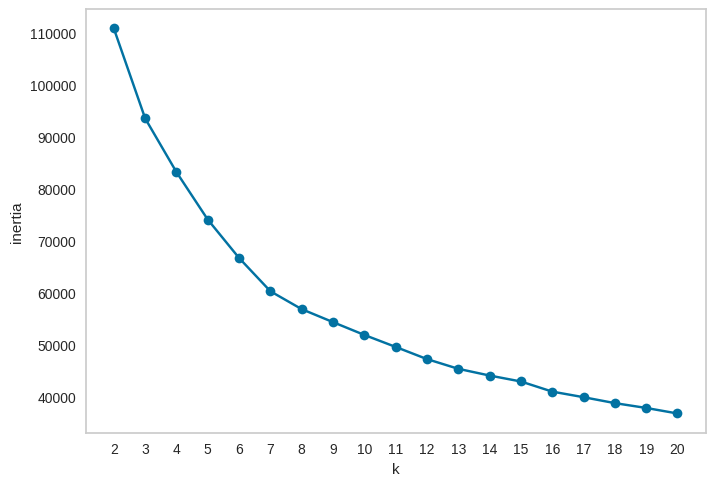

In [ ]:
#[문제 6] for 문을 활용해서 2~20까지 k값을 넣어서 성능지표 확인하기

ks= range(2,21) # k값 범위 지정(range(2,21)) 후 ks 변수에 할당
inertias = []   # 이너셔 결과를 저장하기 위한 빈 리스트 생성 (변수명 inertias)

for k in ks: # for문 활용
    model = KMeans(n_clusters = k, random_state = 2025, n_init = 10)  # k-means 모델 만들기(그룹수 : n_clusters 파라미터 사용,n_init=10)
    model.fit(data)                                                   # 모델 학습
    inertias.append(model.inertia_)                                   # 이너셔 결과를 inertias 리스트에 계속 저장(append 활용)
    print('n_cluster:{}, inertia:{}'.format(k, model.inertia_))
    print('---------') # n_cluster, inertia 결과 출력


plt.Figure(figsize=(15,6))
plt.plot(ks,inertias,'-o') # '-o'는 실선과 원을 같이 시각화
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.grid()
plt.show()

여기서는 확실하게 어떤 k 값이 좋은지 파악하기가 힘들긴 하네요

### <b>**3) [참조]Elbow Method 활용해서 k 값 구하기**
* yellowbrick의 k-Elbow Mehod를 활용해서 최적의 k 값을 구하기(k값 결정하기 쉽게 도와주는 함수)

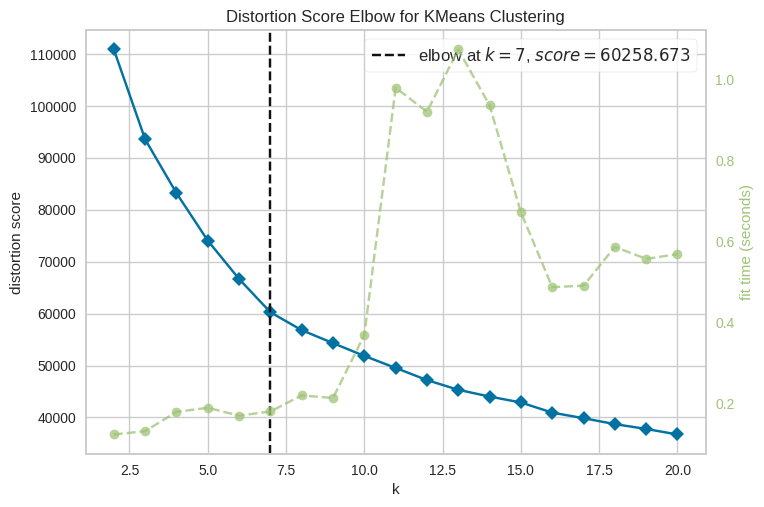

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
#[문제 7] Elbow Method를 통해 최적의 군집 수 도출을 해보자.

# 1. 모델 선언하기(random_state=2025, n_init = 10 으로 설정)(model_E로 할당)

model_E = KMeans(random_state=2025,n_init=10)

# 2. KElbowVisualizer 에 k-means 모델과 k값 넣어서 만들기(Elbow_M 에 할당)
# k값은 k=(2,21)사이의 값중에서 찾는 것으로 넣으면 된다.

Elbow_M = KElbowVisualizer(model_E,k=(2,21))

# 3. Elbow 모델 학습하기(fit)

Elbow_M.fit(data)

# 4. Elbow 모델 확인하기(show()활용)

Elbow_M.show()

### <b>**4) 최적의 k 값으로 모델링**
* Elbow Method를 통해 나온 최적의 k값으로 모델링을 해보자.

In [ ]:
# [문제 8] 원본 데이터('customers_seg.csv') 불러오기

# 1. scale이 안된 원본 data에 clust를 맵핑 시키기 위해 원본 데이터('customers_seg.csv')도 불러옵시다
# data0 라는 변수에 할당하기
data0 = pd.read_csv('customers_seg.csv')

# 2. 'CID'는 활용하지 않을 예정으로 삭제합니다.

data0.drop(columns='CID', inplace = True)
# 3. 데이터 상위 5개 확인하기
data0.head()

,AGE,등록(계/피),고용상태,성별,Willingness to pay/Stay,갱신,상품타입,교육수준,소득,지역,결혼여부,월 납입액,VOC,타 상품 보유 현황,온라인방문빈도,갱신인센티브,판매채널,총지불금액,자동차,거주지사이즈
0,3,피보험자,무직,1,2.62,0,기본,대학졸업,0,도시근교,미혼,80,0,1,자주방문,없음,자사영업,631000,일반세단,소
1,1,계약자,고용,0,6.35,0,기본,고졸이하,102887400,시골,미혼,80,1,4이상,비방문,포인트,인터넷,54000,일반세단,중
2,2,계약자,휴직,0,4.97,0,기본,대학졸업,22159500,도시근교,기혼,60,0,4이상,비방문,할인,자사영업,362000,일반세단,중
3,5,계약자,고용,1,13.48,0,고급,고졸이하,51562500,도시근교,기혼,110,0,2,비방문,할인,자사영업,1264000,컴팩트카,대
4,4,계약자,고용,0,9.78,0,기본,석사,26820200,도시근교,기혼,120,0,3,비방문,없음,대리점,947000,SUV,중


In [ ]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AGE                      12000 non-null  int64  
 1   등록(계/피)                  12000 non-null  object 
 2   고용상태                     12000 non-null  object 
 3   성별                       12000 non-null  int64  
 4   Willingness to pay/Stay  12000 non-null  float64
 5   갱신                       12000 non-null  int64  
 6   상품타입                     12000 non-null  object 
 7   교육수준                     12000 non-null  object 
 8   소득                       12000 non-null  int64  
 9   지역                       12000 non-null  object 
 10  결혼여부                     12000 non-null  object 
 11  월 납입액                    12000 non-null  int64  
 12  VOC                      12000 non-null  int64  
 13  타 상품 보유 현황               12000 non-null  object 
 14  온라인방문빈도               

In [ ]:
# [문제 9] 최적의 k 값으로 k-means 모델을 구성해보자.

#1.최적의 k 값으로 군집 수 선택 (k4에 할당)
k5= 7

# 2. 모델 만들기 (그룹수 : n_clusters 파라미터 사용) (model_B 에 할당)
# 동일값을 위해 random_state=2025, n_init=10으로 설정값을 같이 해본다.
# [참고]n_init의 기본 값이 10 이나 warning을 없애기 위해 지정해준다.

model_B = KMeans(n_clusters = k5,random_state = 2025, n_init = 10)

#3. 스케일링 된 데이터에 학습

model_B.fit(data)

#4. 클러스터링 된 결과 각 데이터가 몇번째 그룹에 속하는지 확인 및 저장(.predict)

cluster = model_B.predict(data)

In [ ]:
# [문제 10] 예측결과와 원본 데이터 합치기

#1. 예측 결과를 데이터프레임으로 만들고

cluster = pd.DataFrame(cluster, columns = ['cluster'])

#2. 원본 데이터와 합쳐서, result로 저장 --> ()안에 작성해보기!

result = pd.concat([data0.reset_index(drop=True),cluster],axis = 1)

#3. 예측 결과는 카테고리 타입으로 변경
result['cluster'] = pd.Categorical(result['cluster'] )
result.head()

#4. 결과 저장 --> 코드 마무리!
result.to_csv('result.csv', index=False)


In [ ]:
result

,AGE,등록(계/피),고용상태,성별,Willingness to pay/Stay,갱신,상품타입,교육수준,소득,지역,...,월 납입액,VOC,타 상품 보유 현황,온라인방문빈도,갱신인센티브,판매채널,총지불금액,자동차,거주지사이즈,cluster
0,3,피보험자,무직,1,2.62,0,기본,대학졸업,0,도시근교,...,80,0,1,자주방문,없음,자사영업,631000,일반세단,소,2
1,1,계약자,고용,0,6.35,0,기본,고졸이하,102887400,시골,...,80,1,4이상,비방문,포인트,인터넷,54000,일반세단,중,3
2,2,계약자,휴직,0,4.97,0,기본,대학졸업,22159500,도시근교,...,60,0,4이상,비방문,할인,자사영업,362000,일반세단,중,2
3,5,계약자,고용,1,13.48,0,고급,고졸이하,51562500,도시근교,...,110,0,2,비방문,할인,자사영업,1264000,컴팩트카,대,0
4,4,계약자,고용,0,9.78,0,기본,석사,26820200,도시근교,...,120,0,3,비방문,없음,대리점,947000,SUV,중,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,1,계약자,고용,1,25.99,0,기본,대학졸업,86451000,도심,...,70,0,2,비방문,설계사독려,인터넷,245000,일반세단,중,3
11996,3,피보험자,고용,0,3.44,1,중급,대학졸업,25962000,도시근교,...,80,0,1,자주방문,할인,자사영업,468000,일반세단,중,1
11997,3,피보험자,무직,1,9.06,0,중급,대학졸업,0,도시근교,...,90,3,2,자주방문,할인,자사영업,977000,일반세단,중,2
11998,4,계약자,고용,1,8.35,0,중급,대학졸업,26366000,도시근교,...,100,0,3,비방문,포인트,자사영업,854000,일반세단,대,4


<b> 각 고객별로 군집 된 번호가 데이터 프레임에 생성한 것을 볼 수 있습니다! 다 왔습니다!

* 이제부터 조별 과제를 수행합니다.
    * 조 내에서 최적의 K값으로 군집을 수행한 결과(result)를 하나 선정해서
    * 모든 조원들이 동일한 데이터를 로딩하고
    * 프로파일링을 시작합니다.


---------------------------------------------------------------------------------------------
# **2. 프로파일링**

<b>프로파일링 이란?
> <b>군집의 구조와 내용을 분석하고 도메인 및 현업업무의 '추론'을 바탕으로 분석의 결과를 적용 가능하도록 하는 과정. 데이터를 통해서 군집별 특성을 파악하는 것에 목적은 두는 기법

<font color="1E90FF"><b>★ 프로파일링을 위해 군집간의 차이를 도메인 및 업무 관점으로 해석해야한다.</font>

* 우리는 총 20개의 컬럼을 clust 별로 업무관점으로 해석하고 정리가 필요하다.
  <br>* 범주형/수치형 데이터 별로도 특징과 해석방법이 조금 다르다
  <br>* 개인별로 약 6개의 변수에 대한 군집간 차이 분석해보기!(하나의 변수당 2명이상이 분석 수행해야 비교가 된다!)

* 도메인 지식을 총 동원 해서 각 컬럼의 clust 별 인사이트를 도출 해 보자!

## **(1) 컬럼 확인해보기**

In [10]:
#[문제 11~12] result에 대해 info를 통해서 범주형/수치형 데이터 확인해보고 어떤 컬럼들이 있었는지 확인
# 1. 데이터 불러오기(조에서 하나의 결과를 선정해서 공유)

result = pd.read_csv('result.csv')

# 2. info로 확인하기
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AGE                      12000 non-null  int64  
 1   등록(계/피)                  12000 non-null  object 
 2   고용상태                     12000 non-null  object 
 3   성별                       12000 non-null  int64  
 4   Willingness to pay/Stay  12000 non-null  float64
 5   갱신                       12000 non-null  int64  
 6   상품타입                     12000 non-null  object 
 7   교육수준                     12000 non-null  object 
 8   소득                       12000 non-null  int64  
 9   지역                       12000 non-null  object 
 10  결혼여부                     12000 non-null  object 
 11  월 납입액                    12000 non-null  int64  
 12  VOC                      12000 non-null  int64  
 13  타 상품 보유 현황               12000 non-null  object 
 14  온라인방문빈도               

<b>cluster 컬럼을 제외하고 그 다음 컬럼인 age 부터 차례대로 군집간의 차이를 업무관점으로 해석해 보기!

[tip]
* 범주형으로 되어있는 컬럼과 수치형으로 되어있는 컬럼이 해석하는 방법이 다르다.
* 컬럼이 어떤 컬럼인지 확인해보고 특징들을 파악해보자.

----------

### **1) AGE**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
AGE,,,,,,,,,,,,,,,,
1,88,0,0,1017,149,177,23,1454,0.09,0.00,0.00,0.64,0.14,0.16,0.02,0.12
2,108,0,480,572,142,163,73,1538,0.11,0.00,0.16,0.36,0.13,0.15,0.07,0.13
3,337,980,2223,0,484,367,384,4775,0.35,0.30,0.74,0.00,0.45,0.34,0.39,0.40
4,220,1769,316,0,250,308,261,3124,0.23,0.54,0.10,0.00,0.23,0.28,0.27,0.26
5,187,547,0,0,54,64,205,1057,0.20,0.17,0.00,0.00,0.05,0.06,0.21,0.09
6,11,11,0,0,0,1,29,52,0.01,0.00,0.00,0.00,0.00,0.00,0.03,0.00
All,951,3307,3019,1589,1079,1080,975,12000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


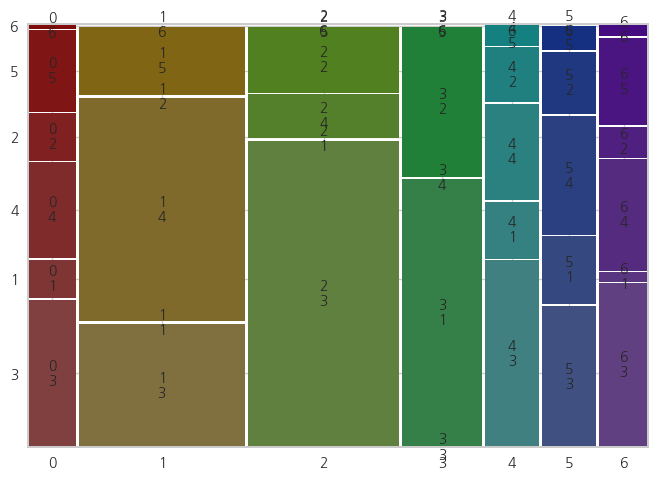

In [15]:
# [같이 하기] 'Age' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.
# crosstab의 margins='True'을 활용하면 행 합, 열 합을 추가할 수 있다.
# pro_df 변수에 할당해서 확인해보자.

feature = 'AGE'

pro_df1 = pd.crosstab([result[feature]], result['cluster'], margins=True)

# 비율로도 한번 확인 해보자.

pro_df2 = pd.crosstab([result[feature]], result['cluster'], margins=True, normalize='columns')
pro_df2 = pro_df2.round(3)

# 합치기, concat
pro_df = pd.concat([pro_df1, pro_df2], axis=1)

# pro_df 확인
display(pro_df)

# 시각화를 해 봅시다.
mosaic(result.sort_values('cluster'), [ 'cluster', feature])
plt.show()

<b>**'age' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[같이 하기]
'''
0 : 균일하게 분포
1 : 2-30대는 제외되어 있는 군집,4-50대의 비중이 높다
2 : 20대와 고령층(6-70대) 은제외되어 있다
3 : 2-30대 만으로 분포
4 : 70대 제외 균일 분포
5,6 : 균일 분포
'''


### **2) 등록(계/피)**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
등록(계/피),,,,,,,,,,,,,,,,
계약자,747,2572,2388,1225,852,875,766,9425,0.06,0.21,0.20,0.10,0.07,0.07,0.06,0.79
피보험자,204,735,631,364,227,205,209,2575,0.02,0.06,0.05,0.03,0.02,0.02,0.02,0.21
All,951,3307,3019,1589,1079,1080,975,12000,0.08,0.28,0.25,0.13,0.09,0.09,0.08,1.00


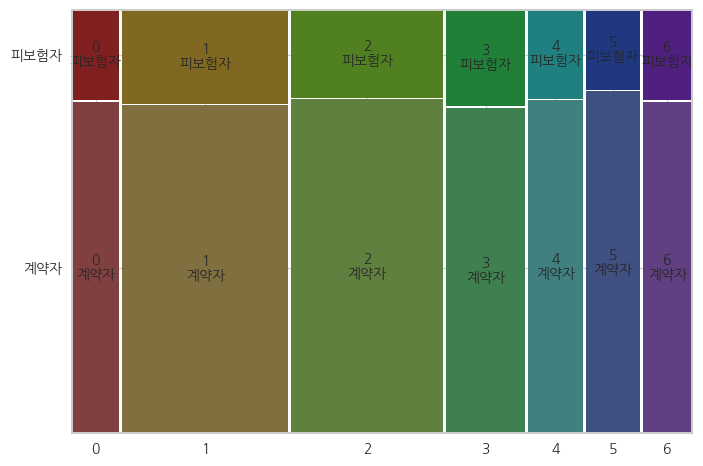

In [16]:
# [문제 13] '등록(계/피)' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature_2 = '등록(계/피)'

pro_df1 = pd.crosstab([result[feature_2]], result['cluster'], margins = True)
pro_df2 = pd.crosstab([result[feature_2]], result['cluster'], margins = True, normalize = True)

pro_df = pd.concat([pro_df1,pro_df2], axis = 1)

display(pro_df)

mosaic(result.sort_values('cluster'),['cluster', feature_2])
plt.show()

<b>**'등록(계/피)' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제 14]
'''
1,2 번 군집에 많은 비율의 고객이 분포되어 있다는 점을 제외하면 큰 특징은 보이지 않는다
계약자/피보험자의 비율이 3~4배 정도로 일정하다
'''

### **3) 성별**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
성별,,,,,,,,,,,,,,,,
0,486,1712,1509,816,596,553,477,6149,0.04,0.14,0.13,0.07,0.05,0.05,0.04,0.51
1,465,1595,1510,773,483,527,498,5851,0.04,0.13,0.13,0.06,0.04,0.04,0.04,0.49
All,951,3307,3019,1589,1079,1080,975,12000,0.08,0.28,0.25,0.13,0.09,0.09,0.08,1.00


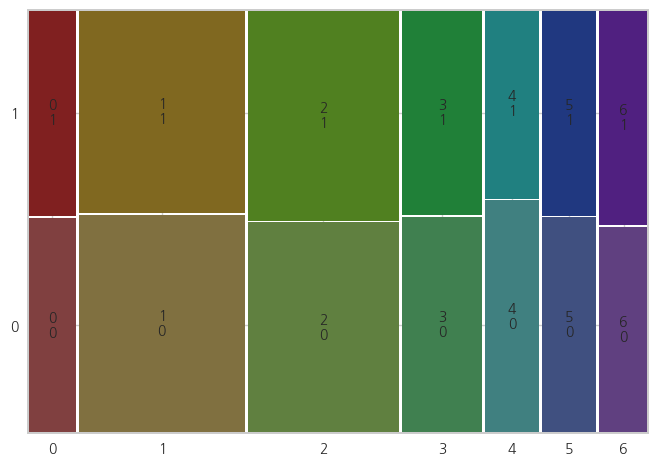

In [17]:
# [문제 15] '성별' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature_3 = '성별'

pro_df1 = pd.crosstab([result[feature_3]], result['cluster'],margins=True)
pro_df2 = pd.crosstab([result[feature_3]], result['cluster'],margins=True,normalize = True)

pro_df = pd.concat([pro_df1,pro_df2], axis = 1)

display(pro_df)

mosaic(result.sort_values('cluster'),['cluster',feature_3])
plt.show()

<b>**'성별' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제16]
'''
1,2 번 군집에 많은 비율의 고객이 분포되어 있다는 점을 제외하면 큰 특징은 보이지 않는다
'''

### **4) willingness to pay/stay(수치)**

Willingness to pay/Stay                  
                            max  min  mean median
cluster                                          
0                         65.21 3.52 11.63   9.42
1                         52.35 2.51  8.08   6.16
2                         49.69 2.05  7.68   5.67
3                         54.86 2.47  8.10   6.19
4                         51.74 2.09  7.53   5.79
5                         49.79 2.44  8.22   6.01
6                         92.50 3.41 15.85  11.24

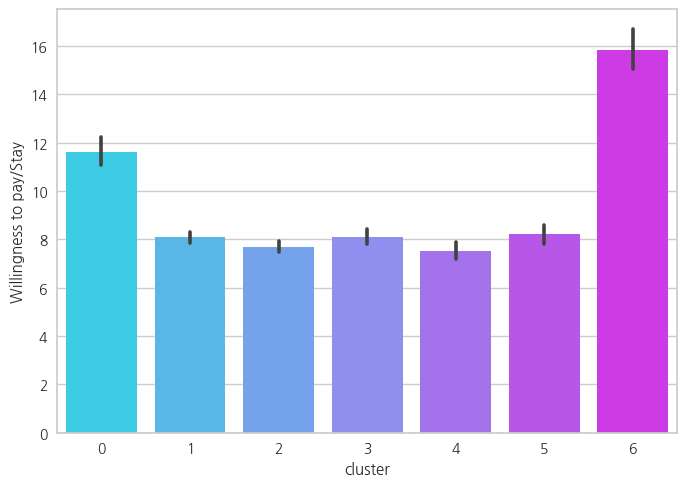

In [18]:
# [같이 하기] WTP의 경우 '보험 유지 기대 확률'로 각 clust 별 min,max,mean,median 통계 값으로 확인해보자.
# groupby 와 agg() 메소드를 활용하여 도출해 보자.

feature = 'Willingness to pay/Stay'
display(result[['cluster',feature]].groupby(['cluster']).agg(['max','min','mean','median']))

# 시각화를 해 봅시다.
sns.barplot(x='cluster', y=feature, data=result, palette='cool')
plt.show()


<b>**'WTP' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
# [같이 하기]
'''
0,6 번 군집의 WTS 가 상대적으로 높은 반면
1,2,3,4,5 번 군집은 8 정도로 균일한 분포를 보인다
1~5번 군집의 경우 WTS 의 mean 값과 비슷하다
6번 군집의 WTS 가 가장 높다는 것을 알 수 있다
'''

### **5) 상품 타입**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
상품타입,,,,,,,,,,,,,,,,
고급,951,0,0,0,1,0,123,1075,0.08,0.00,0.00,0.00,0.00,0.00,0.01,0.09
기본,0,2212,2004,1123,699,709,531,7278,0.00,0.18,0.17,0.09,0.06,0.06,0.04,0.61
중급,0,1095,1015,466,379,371,321,3647,0.00,0.09,0.08,0.04,0.03,0.03,0.03,0.30
All,951,3307,3019,1589,1079,1080,975,12000,0.08,0.28,0.25,0.13,0.09,0.09,0.08,1.00


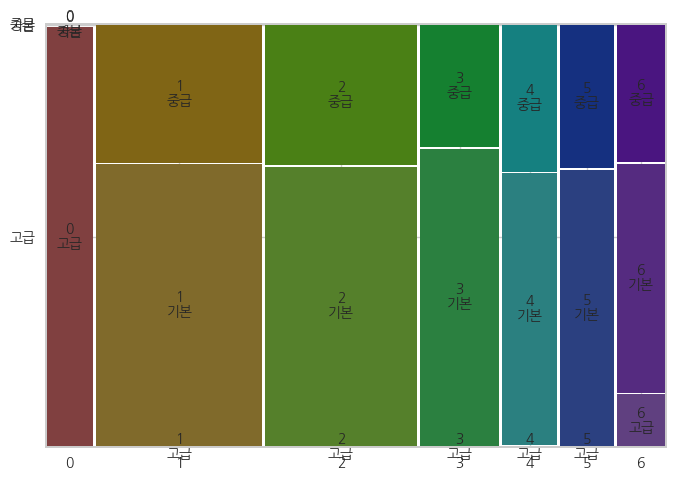

In [19]:
# [문제 17] '상품타입' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature = '상품타입'

pro_df1 = pd.crosstab(result[feature],result['cluster'], margins = True)
pro_df2 = pd.crosstab(result[feature],result['cluster'], margins = True,normalize = True)

pro_df = pd.concat([pro_df1,pro_df2],axis = 1)

display(pro_df)

mosaic(result.sort_values('cluster'),['cluster',feature])
plt.show()

<b>**'상품타입' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제18]
'''
0번 군집에 고급 상품에 들어있는 고객들이 대부분 들어있다(고급 상품을 제외한 다른 상품은 들어있지 않다)
1,2,3,4,5번 군집은 고급상품을 제외한 다른 두 상품을 비슷한 비율로 보유한 고객들이다
6번 군집은 소수의 고급상품 고객과 다른 고객들이 섞여 있다
'''

### **6) 교육수준**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
교육수준,,,,,,,,,,,,,,,,
고졸이하,301,962,1031,516,333,0,334,3477,0.03,0.08,0.09,0.04,0.03,0.00,0.03,0.29
대학졸업,553,2345,1988,1073,602,0,544,7105,0.05,0.20,0.17,0.09,0.05,0.00,0.05,0.59
박사,20,0,0,0,40,353,26,439,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.04
석사,77,0,0,0,104,727,71,979,0.01,0.00,0.00,0.00,0.01,0.06,0.01,0.08
All,951,3307,3019,1589,1079,1080,975,12000,0.08,0.28,0.25,0.13,0.09,0.09,0.08,1.00


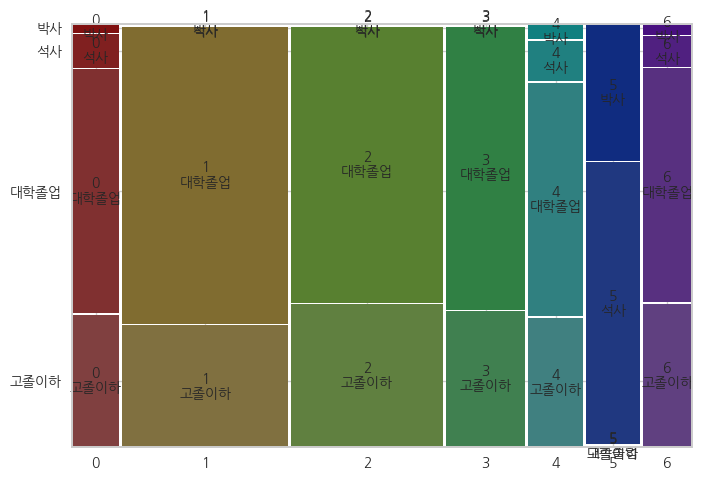

In [20]:
# [문제 19] '교육수준' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature = '교육수준'

pro_df1 = pd.crosstab(result[feature],result['cluster'], margins = True)
pro_df2 = pd.crosstab(result[feature],result['cluster'], margins = True,normalize = True)

pro_df = pd.concat([pro_df1,pro_df2],axis = 1)

display(pro_df)

mosaic(result.sort_values('cluster'),['cluster',feature])
plt.show()

<b>**'교육수준' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제20]
'''
5번 군집의 경우 석,박사 이상의 교육수준을 보유한 고객들이 군집되어있다
1,2,3 번 군집은 석,박사가 포함되어 있지 않다
다른 두 군집은 소수의 석,박사(10%정도의 비율)와 대졸/고졸의 교육수준을 보유한 고객들이 군집되어있다
'''

### **7) 고용상태**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
고용상태,,,,,,,,,,,,,,,,
FALSE,6,0,255,0,39,27,33,360,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.03
고용,611,3307,0,1589,632,800,579,7518,0.05,0.28,0.00,0.13,0.05,0.07,0.05,0.63
무직,233,0,2089,0,285,139,282,3028,0.02,0.00,0.17,0.00,0.02,0.01,0.02,0.25
휴직,101,0,675,0,123,114,81,1094,0.01,0.00,0.06,0.00,0.01,0.01,0.01,0.09
All,951,3307,3019,1589,1079,1080,975,12000,0.08,0.28,0.25,0.13,0.09,0.09,0.08,1.00


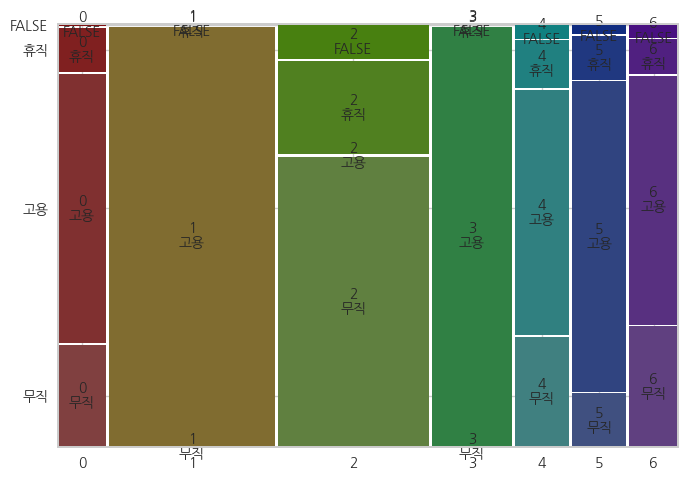

In [21]:
# [문제 21] '고용상태' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature = '고용상태'

pro_df1 = pd.crosstab(result[feature],result['cluster'], margins = True)
pro_df2 = pd.crosstab(result[feature],result['cluster'], margins = True,normalize = True)

pro_df = pd.concat([pro_df1,pro_df2],axis = 1)

display(pro_df)

mosaic(result.sort_values('cluster'),['cluster',feature])
plt.show()

<b>**'고용상태' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제 22]
'''
1,3번 군집은 전부 현직자가 분포되어있다
2번   군집은 현직자가 포함되어 있지 않다
다른  군집은 비슷한 비율로 분포된 것으로 보인다
'''

### **8) 소득(수치)**

소득                                    
               max       min         mean       median
cluster                                               
0        128243500         0  48108641.22  45389300.00
1         96421000  24045000  53765547.90  52493000.00
2         39601100         0   7754089.80         0.00
3        132020900  82386000 101903323.03 100976700.00
4        131727200         0  45125778.41  38944400.00
5        131674400         0  55498152.41  52768500.00
6        130366500         0  40504390.36  35901000.00

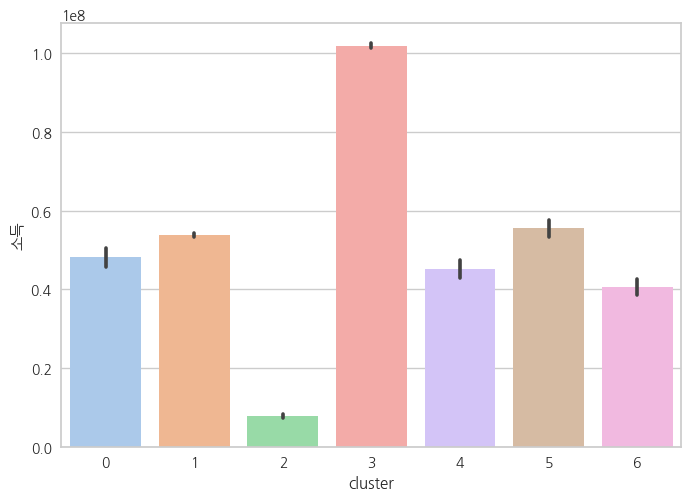

In [22]:
# [문제 23] '소득'은 수치형으로 각 clust 별 min,max,mean,median 통계 값으로 확인해보자.
# groupby 와 agg() 메소드를 활용하여 도출해 보자.

feature = '소득'

display(result[[feature,'cluster']].groupby(['cluster']).agg(['max','min','mean','median']))

sns.barplot(x='cluster',y = feature, data = result, palette = 'pastel')
plt.show()

<b>**'소득' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제24]
'''
3번 군집의 소득이 다른 군집에 비해 높다는 것을 알 수 있다(고소득자)
2번 군집의 경우 소득이 매우 낮다
다른 군집의 경우 비슷한 수준을 보이고 있다(중위)
'''

### **9) 결혼여부**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
결혼여부,,,,,,,,,,,,,,,,
기혼,570,2232,1187,1073,676,702,517,6957,0.05,0.19,0.10,0.09,0.06,0.06,0.04,0.58
미혼,381,1075,1832,516,403,378,458,5043,0.03,0.09,0.15,0.04,0.03,0.03,0.04,0.42
All,951,3307,3019,1589,1079,1080,975,12000,0.08,0.28,0.25,0.13,0.09,0.09,0.08,1.00


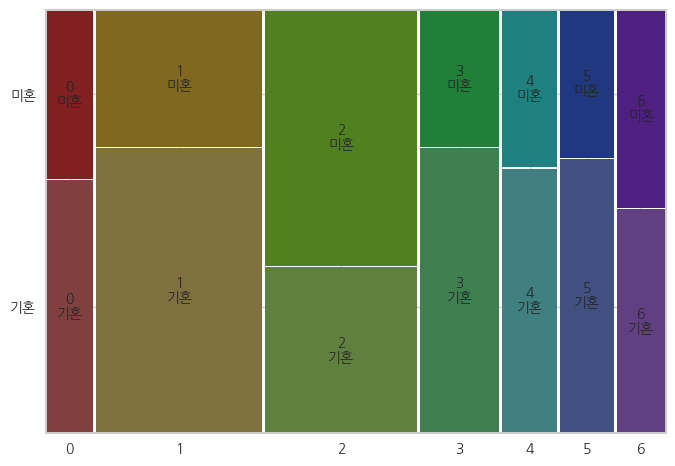

In [23]:
# [문제 25] '결혼여부' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.
feature = '결혼여부'

prp_df1 = pd.crosstab(result[feature],result['cluster'],margins = True)
prp_df2 = pd.crosstab(result[feature],result['cluster'],margins = True,normalize = True)

pro_df = pd.concat([prp_df1, prp_df2], axis = 1)

display(pro_df)

mosaic(result.sort_values('cluster'),['cluster',feature])
plt.show()



<b>**'결혼여부' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제26]
# 각 군집별 큰 구분점은 보이지 않는다

### **10) 월 납입액(수치)**

월 납입액                   
          max  min   mean median
cluster                         
0         230  110 135.30 120.00
1         160   60  87.70  80.00
2         160   60  88.68  80.00
3         160   60  87.59  80.00
4         160   60  88.28  80.00
5         160   60  88.50  80.00
6         350  100 189.06 190.00

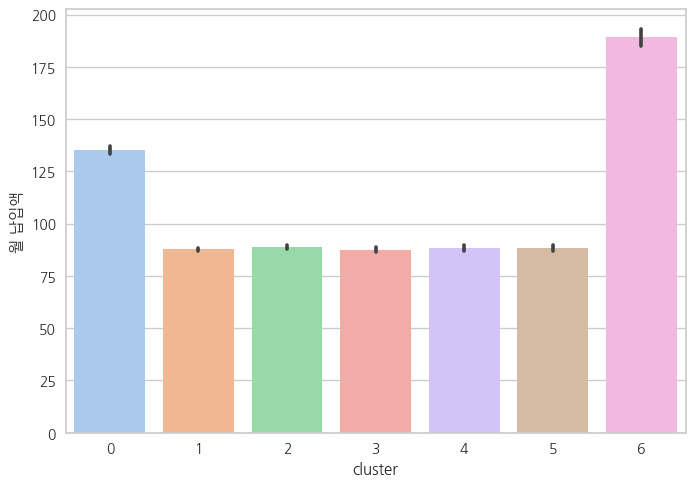

In [24]:
# [문제 27] '월 납입액'은 수치형으로 각 clust 별 min,max,mean,median 통계 값으로 확인해보자.
# groupby 와 agg() 메소드를 활용하여 도출해 보자.

feature = '월 납입액'

display(result[['cluster',feature]].groupby('cluster').agg(['max','min','mean','median']))

sns.barplot(x='cluster',y = feature, data = result, palette = 'pastel')
plt.show()

<b>**'월 납입액' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제28]
'''
6번 군집의 월 납입액이 1~5번 군집에 비해 2배가량 높다
0번 군집의 월 납입액이 상대적으로 높은 편이다
1~5번 군집의 월 납입액은 비슷한 수준이다
'''

### **11) VOC**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
VOC,,,,,,,,,,,,,,,,
0,764,2614,2399,1266,847,850,775,9515,0.06,0.22,0.20,0.11,0.07,0.07,0.06,0.79
1,99,380,329,156,107,131,111,1313,0.01,0.03,0.03,0.01,0.01,0.01,0.01,0.11
2,49,124,124,65,51,34,48,495,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.04
3,24,105,101,69,41,35,30,405,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.03
4,9,62,44,19,27,27,8,196,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.02
5,6,22,22,14,6,3,3,76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
All,951,3307,3019,1589,1079,1080,975,12000,0.08,0.28,0.25,0.13,0.09,0.09,0.08,1.00


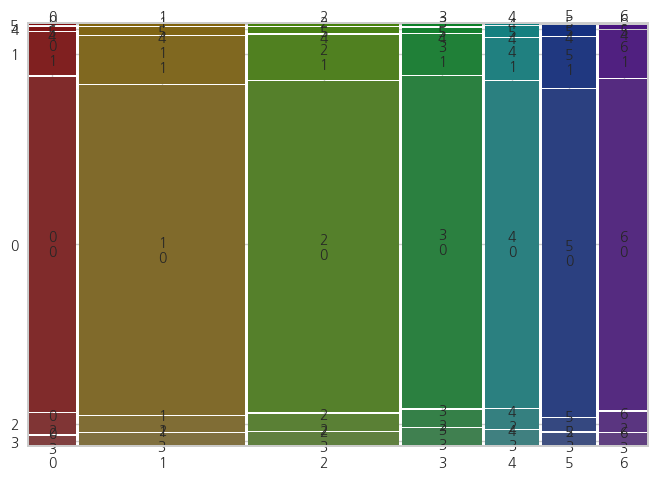

In [25]:
# [문제 29] 'VOC' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.
feature = 'VOC'

prp_df1 = pd.crosstab(result[feature],result['cluster'],margins = True)
prp_df2 = pd.crosstab(result[feature],result['cluster'],margins = True,normalize = True)

pro_df = pd.concat([prp_df1, prp_df2], axis = 1)

display(pro_df)

mosaic(result.sort_values('cluster'),['cluster',feature])
plt.show()


<b>**'VOC' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제30]
'''
0번 군집의 VOC 비율이 다른 군집에 비해 높은 편이다
1번 군집의 경우 0번 군집에 비해 1/7 정도 수준의 VOC 비율을 가지고 있다
다른 군집의 경우 VOC 비율이 매우 작은 편이다
'''

### **12) 타 상품 보유 현황**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
타 상품 보유 현황,,,,,,,,,,,,,,,,
1,329,1163,1026,568,439,403,355,4283,0.03,0.10,0.09,0.05,0.04,0.03,0.03,0.36
2,267,850,783,359,251,262,245,3017,0.02,0.07,0.07,0.03,0.02,0.02,0.02,0.25
3,120,421,391,229,132,147,105,1545,0.01,0.04,0.03,0.02,0.01,0.01,0.01,0.13
4이상,235,873,819,433,257,268,270,3155,0.02,0.07,0.07,0.04,0.02,0.02,0.02,0.26
All,951,3307,3019,1589,1079,1080,975,12000,0.08,0.28,0.25,0.13,0.09,0.09,0.08,1.00


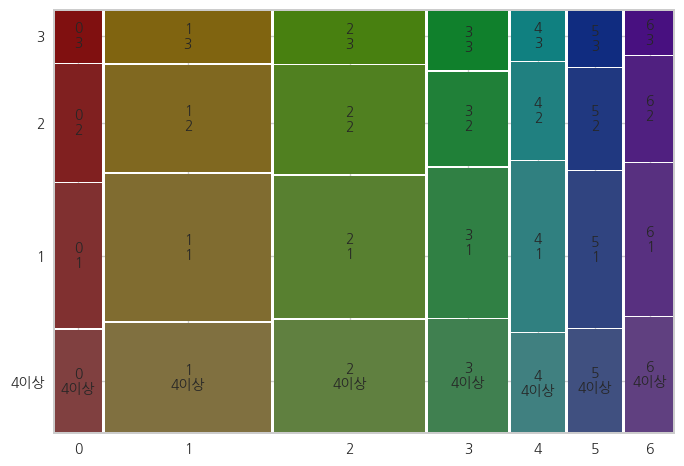

In [26]:
# [문제 31] '타 상품 보유 현황' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature = '타 상품 보유 현황'

prp_df1 = pd.crosstab(result[feature],result['cluster'],margins = True)
prp_df2 = pd.crosstab(result[feature],result['cluster'],margins = True,normalize = True)

pro_df = pd.concat([prp_df1, prp_df2], axis = 1)

display(pro_df)

mosaic(result.sort_values('cluster'),['cluster',feature])
plt.show()

<b>**'타 상품 보유 현황	' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제32]

# 타 상품 보유 현황의 경우 모든 군집에서 비슷한 수준의 비율로 분포되어있다

### **13) 갱신 인센티브**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
갱신인센티브,,,,,,,,,,,,,,,,
설계사독려,255,1141,718,701,382,381,287,3865,0.02,0.10,0.06,0.06,0.03,0.03,0.02,0.32
없음,64,441,240,228,118,149,98,1338,0.01,0.04,0.02,0.02,0.01,0.01,0.01,0.11
포인트,145,572,433,233,159,197,152,1891,0.01,0.05,0.04,0.02,0.01,0.02,0.01,0.16
할인,487,1153,1628,427,420,353,438,4906,0.04,0.10,0.14,0.04,0.04,0.03,0.04,0.41
All,951,3307,3019,1589,1079,1080,975,12000,0.08,0.28,0.25,0.13,0.09,0.09,0.08,1.00


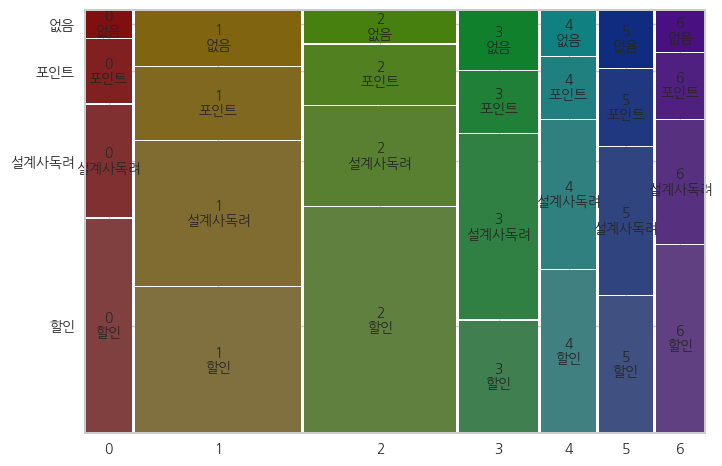

In [27]:
# [문제 33] '갱신인센티브' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature = '갱신인센티브'

prp_df1 = pd.crosstab(result[feature],result['cluster'],margins = True)
prp_df2 = pd.crosstab(result[feature],result['cluster'],margins = True,normalize = True)

pro_df = pd.concat([prp_df1, prp_df2], axis = 1)

display(pro_df)

mosaic(result.sort_values('cluster'),['cluster',feature])
plt.show()

<b>**'갱신인센티브	' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제 34]
# 각 군집별로 큰 차이를 보이지 않는다

### **14) 총 지불 금액(수치)**

총지불금액                           
             max   min       mean    median
cluster                                    
0        2663000  1000  717643.53 674000.00
1        1512000  1000  421922.89 409000.00
2        1919000  3000  622037.43 578000.00
3        1040000     0  343249.84 351000.00
4        1700000  1000  448273.40 427000.00
5        1340000  2000  380673.15 385000.00
6        3573000  2000 1057515.90 957000.00

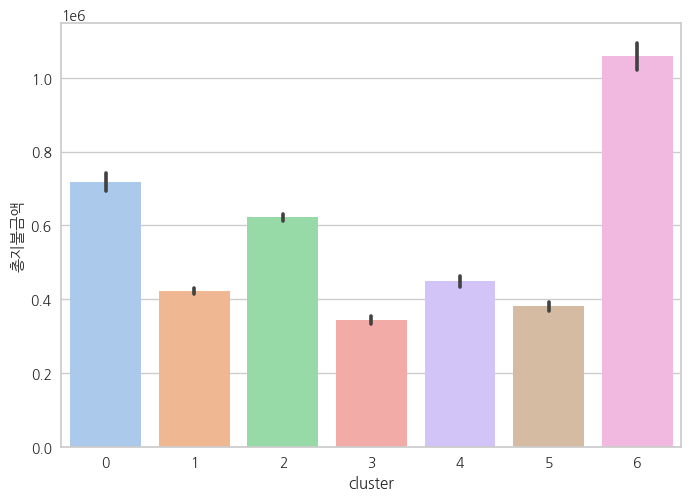

In [28]:
# [문제 35] '총지불금액'은 수치형으로 각 clust 별 min,max,mean,median 통계 값으로 확인해보자.
# groupby 와 agg() 메소드를 활용하여 도출해 보자.

feature = '총지불금액'

display(result[['cluster',feature]].groupby('cluster').agg(['max','min','mean','median']))

# 시각화를 해 봅시다.
sns.barplot(x = 'cluster', y = feature, data = result, palette = 'pastel')
plt.show()

<b>**'총지불금액' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제 36]
'''
6번 군집의 총 지불금액이 다른 군집에 비해 높은 편이다
0,2번 군집의 지불금액이 1,3,4,5 군집에 비해 더 높은 편이다
1,3,4,5 번 군집의 경우 비슷한 보험금을 지불 받은 고객들로 분포되어있다
'''

### **15) 자동차**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
자동차,,,,,,,,,,,,,,,,
SUV,194,716,698,315,209,200,4,2336,0.02,0.06,0.06,0.03,0.02,0.02,0.00,0.19
고급차,0,0,0,0,0,0,454,454,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.04
스포츠카,6,5,5,46,34,39,517,652,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.05
일반세단,556,1879,1653,833,564,589,0,6074,0.05,0.16,0.14,0.07,0.05,0.05,0.00,0.51
컴팩트카,195,707,663,395,272,252,0,2484,0.02,0.06,0.06,0.03,0.02,0.02,0.00,0.21
All,951,3307,3019,1589,1079,1080,975,12000,0.08,0.28,0.25,0.13,0.09,0.09,0.08,1.00


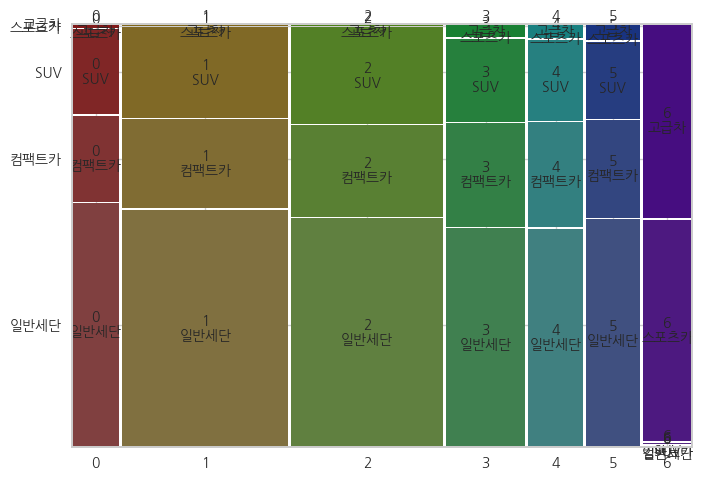

In [29]:
# [문제 37] '자동차' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature = '자동차'

prp_df1 = pd.crosstab(result[feature],result['cluster'],margins = True)
prp_df2 = pd.crosstab(result[feature],result['cluster'],margins = True,normalize = True)

pro_df = pd.concat([prp_df1, prp_df2], axis = 1)

display(pro_df)

mosaic(result.sort_values('cluster'),['cluster',feature])
plt.show()

<b>**'자동차' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제38]
# 대부분의 고급차/스포츠카는 6번 군집이 보유하고 있다

 ### **16) 거주지 사이즈**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
거주지사이즈,,,,,,,,,,,,,,,,
대,85,0,0,0,1079,0,81,1245,0.01,0.00,0.00,0.00,0.09,0.00,0.01,0.10
소,185,699,675,343,0,249,181,2332,0.02,0.06,0.06,0.03,0.00,0.02,0.02,0.19
중,681,2608,2344,1246,0,831,713,8423,0.06,0.22,0.20,0.10,0.00,0.07,0.06,0.70
All,951,3307,3019,1589,1079,1080,975,12000,0.08,0.28,0.25,0.13,0.09,0.09,0.08,1.00


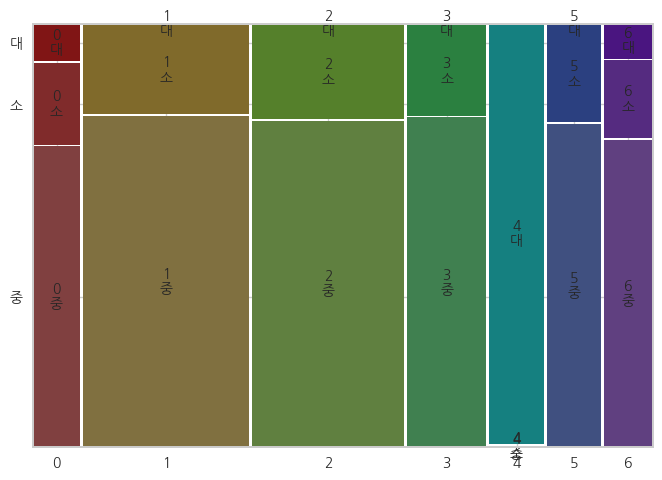

In [30]:
# [문제 39] '거주지사이즈' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.
feature = '거주지사이즈'

prp_df1 = pd.crosstab(result[feature],result['cluster'],margins = True)
prp_df2 = pd.crosstab(result[feature],result['cluster'],margins = True,normalize = True)

pro_df = pd.concat([prp_df1, prp_df2], axis = 1)

display(pro_df)

mosaic(result.sort_values('cluster'),['cluster',feature])
plt.show()


<b>**'거주지사이즈' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제40]

# 4번 군집은 모두 거주지 사이즈가 '대'로 이루어져있다

### **17) 갱신**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
갱신,,,,,,,,,,,,,,,,
0,825,2908,2540,1386,868,922,835,10284,0.07,0.24,0.21,0.12,0.07,0.08,0.07,0.86
1,126,399,479,203,211,158,140,1716,0.01,0.03,0.04,0.02,0.02,0.01,0.01,0.14
All,951,3307,3019,1589,1079,1080,975,12000,0.08,0.28,0.25,0.13,0.09,0.09,0.08,1.00


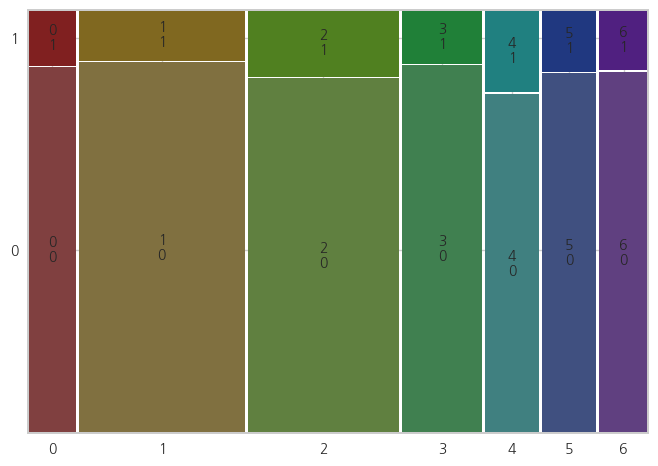

In [31]:
# [문제 41] '갱신' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature = '갱신'

prp_df1 = pd.crosstab(result[feature],result['cluster'],margins = True)
prp_df2 = pd.crosstab(result[feature],result['cluster'],margins = True,normalize = True)

pro_df = pd.concat([prp_df1, prp_df2], axis = 1)

display(pro_df)

mosaic(result.sort_values('cluster'),['cluster',feature])
plt.show()

<b>**'갱신' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제42]
# 큰 특징을 보이지 않는다

### **18) 지역**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
지역,,,,,,,,,,,,,,,,
도시근교,658,1772,2754,539,648,469,732,7572,0.05,0.15,0.23,0.04,0.05,0.04,0.06,0.63
도심,111,770,130,505,175,268,125,2084,0.01,0.06,0.01,0.04,0.01,0.02,0.01,0.17
시골,182,765,135,545,256,343,118,2344,0.02,0.06,0.01,0.05,0.02,0.03,0.01,0.20
All,951,3307,3019,1589,1079,1080,975,12000,0.08,0.28,0.25,0.13,0.09,0.09,0.08,1.00


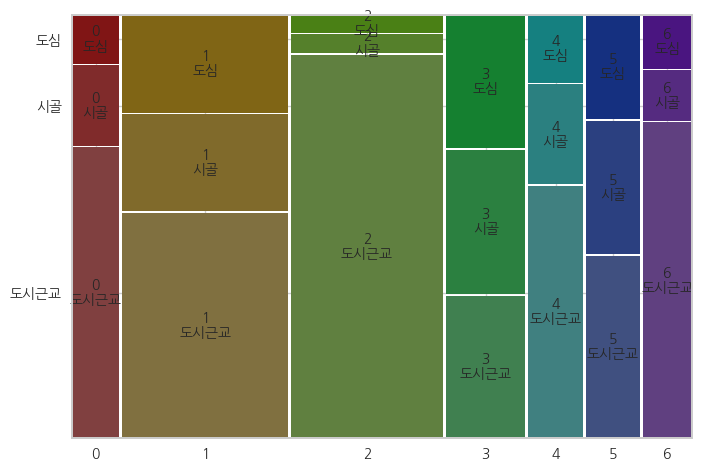

In [32]:
# [문제 43] '지역' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature = '지역'

prp_df1 = pd.crosstab(result[feature],result['cluster'],margins = True)
prp_df2 = pd.crosstab(result[feature],result['cluster'],margins = True,normalize = True)

pro_df = pd.concat([prp_df1, prp_df2], axis = 1)

display(pro_df)

mosaic(result.sort_values('cluster'),['cluster',feature])
plt.show()

<b>**'지역' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제44]
# 3번 군집에 도시근교에 거주하는 고객들이 비교적 높은 비율로 분포되어 있다

### **19) 온라인방문빈도**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
온라인방문빈도,,,,,,,,,,,,,,,,
비방문,713,2438,2266,1149,809,832,721,8928,0.06,0.20,0.19,0.10,0.07,0.07,0.06,0.74
자주방문,204,735,631,364,227,205,209,2575,0.02,0.06,0.05,0.03,0.02,0.02,0.02,0.21
종종,34,134,122,76,43,43,45,497,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.04
All,951,3307,3019,1589,1079,1080,975,12000,0.08,0.28,0.25,0.13,0.09,0.09,0.08,1.00


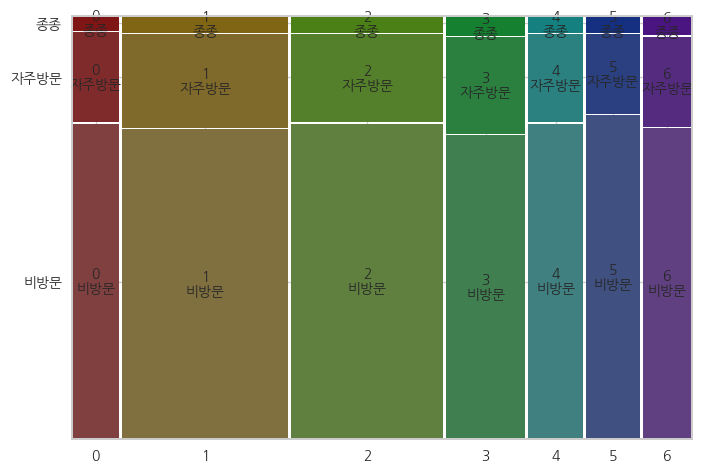

In [33]:
# [문제 45] '온라인방문빈도' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.

feature = '온라인방문빈도'

prp_df1 = pd.crosstab(result[feature],result['cluster'],margins = True)
prp_df2 = pd.crosstab(result[feature],result['cluster'],margins = True,normalize = True)

pro_df = pd.concat([prp_df1, prp_df2], axis = 1)

display(pro_df)

mosaic(result.sort_values('cluster'),['cluster',feature])
plt.show()

<b>**'온라인방문빈도' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제46]
# 큰 특징을 보이지 않는다

### **20) 판매채널**

cluster,0,1,2,3,4,5,6,All,0,1,2,3,4,5,6,All
판매채널,,,,,,,,,,,,,,,,
대리점,341,1272,1216,593,385,400,385,4592,0.03,0.11,0.10,0.05,0.03,0.03,0.03,0.38
인터넷,149,466,438,238,141,145,163,1740,0.01,0.04,0.04,0.02,0.01,0.01,0.01,0.14
자사영업,271,938,803,420,334,321,262,3349,0.02,0.08,0.07,0.04,0.03,0.03,0.02,0.28
콜센터,190,631,562,338,219,214,165,2319,0.02,0.05,0.05,0.03,0.02,0.02,0.01,0.19
All,951,3307,3019,1589,1079,1080,975,12000,0.08,0.28,0.25,0.13,0.09,0.09,0.08,1.00


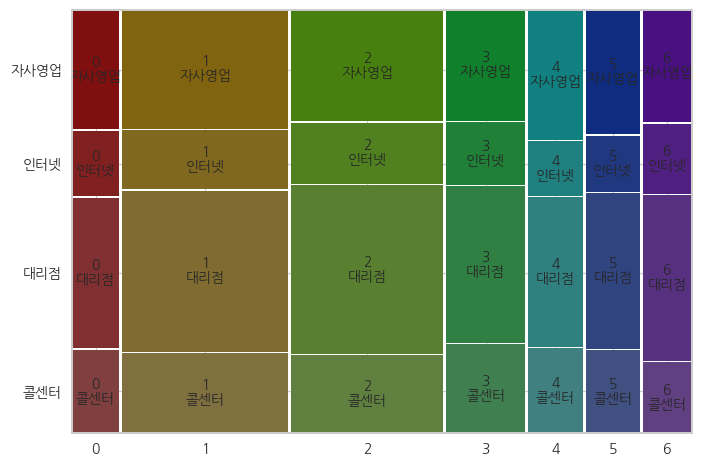

In [34]:
# [문제 47] '판매채널' 열에 대해 crosstab을 활용해서 clust별 범주별 합계를 확인 해보자.
feature = '판매채널'

prp_df1 = pd.crosstab(result[feature],result['cluster'],margins = True)
prp_df2 = pd.crosstab(result[feature],result['cluster'],margins = True,normalize = True)

pro_df = pd.concat([prp_df1, prp_df2], axis = 1)

display(pro_df)

mosaic(result.sort_values('cluster'),['cluster',feature])
plt.show()


<b>**'판매채널' 변수에 대한 클러스터별 특징을 파악해보고 아래 주석에 적어보자!**
( 바로 ppt에 작성을 해도 상관없다)

In [ ]:
#[문제48]
# 큰 특징을 보이지 않는다

---------------------------------------------------------------------------------------------
## **(2) 결과 정리**

<font color="1E90FF"><b>★ 20가지 피쳐값에 대해 군집별로 분석해 보았고 인사이트도 도출해 보았다. 한번 ppt에 정리해보자!</font>

## **[Mission 3-분석모델 개발]**

* k-means 활용해 군집화 분석 모델 개발 완료
* 프로파일링 기법을 통해 각 피쳐의 군집별 특성에 대해 파악하고 정의 해봄
* 정의 한 것을 가지고 고객 군집별 마케팅 전략 수립

<font color="1E90FF"><b>→ 여러분들은 어떻게 군집에 대해 정의를 내리고 마케팅 방안을 수립하였나요?<br><b>서로의 군집에 대해서 이야기해 보고 발표해 봅시다.<b><br>
    

# <b>Mission 3 완료!
수고하셨습니다!